%matplotlib inline 是 Jupyter Notebook（或 IPython）中的一个 ​​魔法命令（Magic Command）​​，用于在 Notebook 中​​直接内嵌显示 matplotlib 绘制的图形​​，而无需手动调用 plt.show()。以下是详细解释

In [2]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random


生成数据集

In [3]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape) # 噪声

In [4]:
features[0], labels[0]

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>,
 
 [6.000587]
 <NDArray 1 @cpu(0)>)

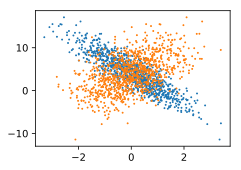

In [8]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);  # 加分号只显示图
plt.scatter(features[:, 0].asnumpy(), labels.asnumpy(), 1);

### 读取数据集

**生成小批量数据 batch**

In [10]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)  # take函数根据索引返回对应元素

`yield`使得函数变成一个​​生成器（generator）​​，每次调用返回一个批次的数据，而不是一次性加载所有数据（节省内存）。

In [11]:
batch_size = 10 

for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break


[[ 0.42469677 -1.5595479 ]
 [-1.480558   -0.68010134]
 [-0.98427486  0.20189847]
 [-0.6496574   1.3733644 ]
 [-0.64220035  0.77557075]
 [ 0.6158901  -0.2633307 ]
 [-1.1598114   0.55044216]
 [-1.3599228   0.57972157]
 [-1.6947321  -0.873005  ]
 [ 0.57938355 -1.856082  ]]
<NDArray 10x2 @cpu(0)> 
[ 1.0342949e+01  3.5594604e+00  1.5349473e+00 -1.7663952e+00
  2.7106720e-01  6.3159738e+00 -7.3939674e-03 -4.8840913e-01
  3.7805295e+00  1.1677933e+01]
<NDArray 10 @cpu(0)>


### 初始化模型参数

In [15]:
w = nd.random.normal(scale=0.01,shape = (num_inputs,1))
b = nd.zeros(shape=(1,))

print(w)
print(b)

w.attach_grad()
b.attach_grad()


[[-0.00491778]
 [-0.01556092]]
<NDArray 2x1 @cpu(0)>

[0.]
<NDArray 1 @cpu(0)>


### 定义模型

In [16]:
def linreg(X, w, b):
    return nd.dot(X,w) + b

### 定义损失函数

In [27]:
def squared_loss(y_hat ,y):
    # print(y_hat.shape,y.shape) 
    return (y_hat - y.reshape(y_hat.shape)) **2 / 2

In [ ]:
def squared_loss(y_hat ,y):
    
    return (y_hat - y) **2 / 2

### 定义优化算法

In [18]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh包中方便以后使用
    for param in params:
        param[:] = param - lr * param.grad / batch_size

`param[:]`表示就地更新参数值;
param.grad 表示梯度,如何得到?
$$\text{param} \leftarrow \text{param}-\eta · \frac {\nabla param}{|\mathcal{B}|}$$

### 训练模型

In [28]:
lr = 0.03 # 学习率
num_epochs = 3 # 迭代次数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050


In [ ]:
true_w, w

([2, -3.4],
 
 [[ 1.9997464]
  [-3.399488 ]]
 <NDArray 2x1 @cpu(0)>)

In [ ]:
true_b, b

(4.2,
 
 [4.1997137]
 <NDArray 1 @cpu(0)>)

- 问题1:为什么`squared_loss`函数中需要使用`reshape`函数？

`y_hat`输入时为矩阵,而`y`为向量.

- 问题2:如果样本个数不能被批量大小整除，data_iter函数的行为会有什么变化？

其最后一组取样会取余数个样本.